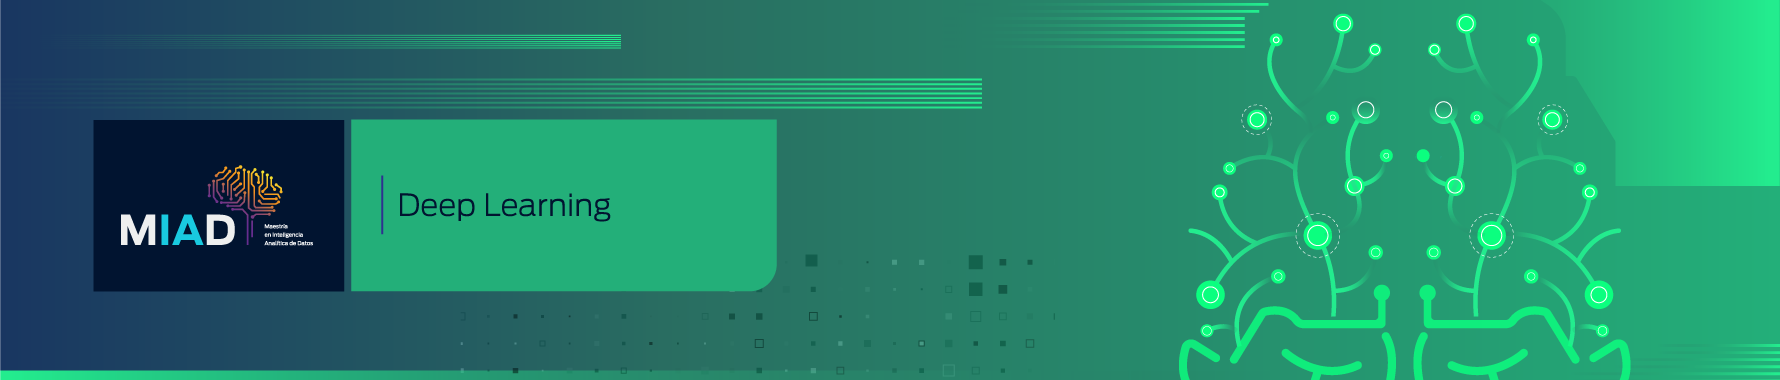

# Deep learning - Semana 7
## Aplicación de GRU (Gated Recurrent Unit) para análisis de sentimiento de texto.

### Propósito

El análisis de sentimiento es una aplicación de procesamiento de lenguaje natural que identifica el tono emocional o la opinión de un texto. Por lo general, las emociones o actitudes hacia un tema pueden ser positivas, negativas o neutrales. Esto convierte al análisis de sentimiento en una tarea de clasificación de texto. En esta actividad se revisará la aplicación del modelo Gated Recurrent Unit (GRU) utilizando el paquete _Keras_, donde se explorará su potencial y capacidad predictiva. Finalmente, habrá una actividad calificada por el personal sobre un conjunto de datos donde deberá calibrar una red GRU.

### Instrucciones generales

1. Para realizar la actividad solo siga las indicaciones asociadas a cada celda del notebook. 

2. En las partes iniciales, siéntase libre de modificar el archivo agregando celdas, lo que le permitirá afianzar su comprensión sobre las distintas funcionalidades de código.

### Definición de GRU

Esta red es una versión más simple de LSTM ya que implica el entrenamiento de un menor número de parámetros; sin embargo, es bastante robusta y ha mostrado un gran desempeño en análisis de procesos secuenciales como, por ejemplo, para el análisis de sentimiento de un texto. Comparte la misma idea básica de LSTM, utilizar una serie de puertas (_gates_) para actualizar el estado oculto (_hidden state_) de la red, la cual hace la función de seleccionar qué información del pasado se conserva en el futuro, así como decidir cómo influye la información de entrada que se va ingresando. En el siguiente esquema se puede detallar el modelo:

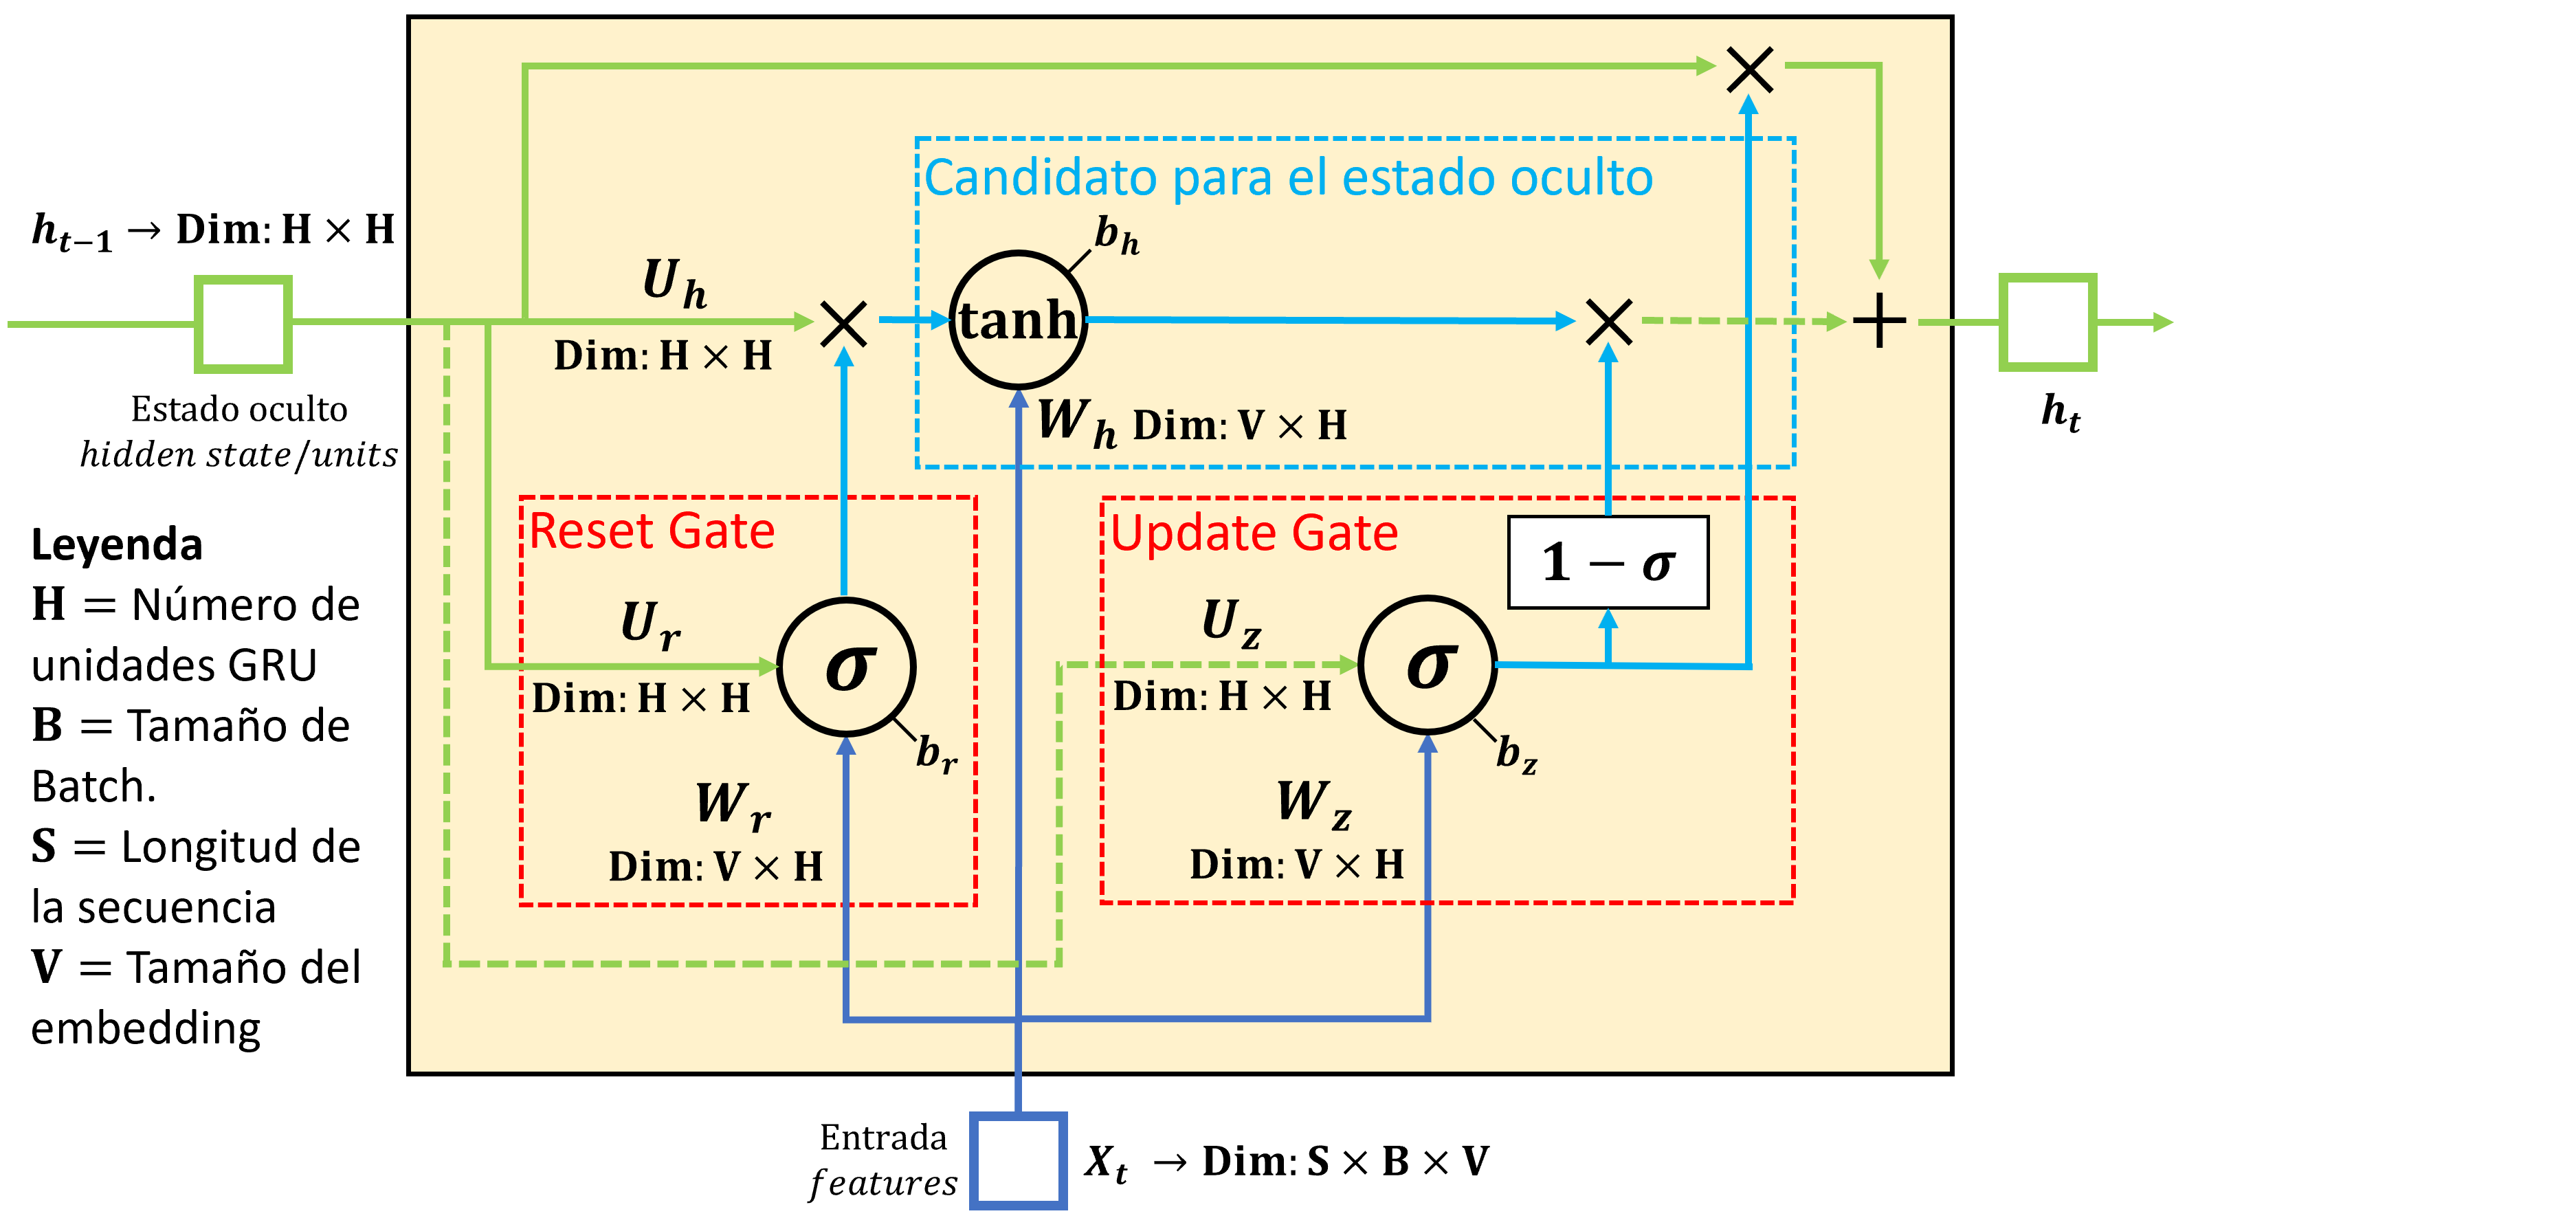

En una celda GRU, se tienen tres puertas que se encargan de decidir el flujo de información:
*   **Puerta de reseteo (_Reset Gate_) $r$:** Determina cuánto conocimiento pasado es olvidado.
*   **Puerta de actualización (_Update Gate_) $z$:** Determina cuánto conocimiento previo necesita ser pasado al futuro.
*   **Puerta de selección de estado (_Current Memory Gate_) $h$:** Determina la información del pasado y actual (de entrada) que será enviada al siguiente estado oculto.

De forma análoga a LSTM, el entrenamiento se puede realizar de forma recursiva concatenando celdas GRU para cada una de las entradas $X_t$. También, es importante notar que cada puerta tiene dos tipos de pesos: con respecto a la entrada se calibran los pesos $W$ que dependen del tamaño de embedding del input y el número de unidades; por otra parte, los pesos $U$ se calibran para los estados ocultos y su cantidad total depende únicamente del número de unidades GRU. Así mismo, cada puerta tiene su número de sesgos. En resumen, el número total de parámetros, teniendo en cuenta las dimensiones del esquema, sigue la ecuación $3\times ((H+V)\times H+2H)$.

### Implementación en Keras/Tensorflow

Para interactuar con los diferentes componentes de la red, implementaremos GRU utilizando la capa que ofrece _Keras_ mediante la aplicación en un ejemplo. En primer lugar, importaremos las librerías requeridas:

In [ ]:
import re, os
import math
import pandas as pd
import numpy as np
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
#La siguiente línea evita la generación de "warnings" y "flags" al importar keras y tensorflow.
#Dichas advertencias no comprometen el funcionamiento del código.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#Importación de keras y tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer

A manera de ejemplo, realizaremos un análisis de sentimiento de las _reviews_ de IMDB. A continuación, cargamos los datos:

In [ ]:
data = pd.read_csv('IMDB Dataset.csv')
data

Como estas reseñas provienen de un sitio web, los strings contienen tags de HTML que no interesan para el análisis, por lo que es necesario removerlos. También, es posible que hayan URLs y carácteres no alfanúmericos que no son necesario para comprender el mensaje. La siguiente función elimina estos caracteres y pasa todos los caracteres a minúsculas para simplificar la información.

In [ ]:
def remove_tags(string):
    removelist = ""
    p = re.compile(r'<.*?>')
    result = p.sub('',string) #remove HTML tags
    result = re.sub(r'http\S+', '',result) #remove URLs
    result = re.sub(r'[\W_'+removelist+']', ' ', result) #remove non-alphanumeric characters
    result = result.lower()
    return result
data['review']=data['review'].apply(lambda cw : remove_tags(cw))
data

A diferencia del laboratorio formativo "Redes Neuronales Recurrentes para Procesamiento de Lenguaje Natural (NLP)", donde se buscaba predecir la siguiente palabra en una secuencia, en análisis de sentimiento interesa la emocionalidad del mensaje de la frase en general. Gracias a esto podemos deshacernos de algunas palabras que no aportan significado al mensaje y así reducir el tamaño del corpus y facilitar el entrenamiento. Las palabras que eliminaremos serán las "stopwords", entre las que se encuentran, por ejemplo, preposiciones. El paquete `ntlk` posee una lista con estas palabras que se removerán del corpus:

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data

Ahora, realizaremos la lematización sobre el texto. Esta es una técnica útil para obtener la raiz de las palabras, lo cual se conoce como _lemma_. Así, por ejemplo, podemos asociar todas las conjugaciones de un verbo a una misma palabra (de esta maner, las palabras _reading_, _reads_, _read_ comparte la palabra _read_). Esto reduce el número de palabras a ser entrenadas dejando las que tienen significados distintos que aportan al mensaje. Este proceso se realiza con la función `WordNetLemmatizer()` de `ntlk`. Antes, el texto debe ser dividido en palabras individuales utilizando `WhitespaceTokenizer()` de `ntlk`. La siguiente función realiza la lematización sobre _tokens_ individuales:

In [ ]:
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
data['review'] = data.review.apply(lemmatize_text)
data

Revisemos algunas estadísticas básicas de las reseñas que nos servirá para decidir algunos hipérparámetros más adelante:

In [ ]:
s = 0.0
for i in data['review']:
    word_list = i.split()
    s = s + len(word_list)
print("Longitud promedio de cada reseña : ",s/data.shape[0])
print("Máxima longitud de una reseña: ", len(max(data['review'], key=len)))
pos = 0
for i in range(data.shape[0]):
    if data.iloc[i]['sentiment'] == 'positive':
        pos = pos + 1
neg = data.shape[0]-pos
print("Porcentaje de reseñas con sentimiento positivo: "+str(pos/data.shape[0]*100)+"%")
print("Porcentaje de reseñas con sentimiento negativo: "+str(neg/data.shape[0]*100)+"%")

Utilizando la función `LabelEncoder()` de `sklearn.preprocessing`, convertimos las etiquetas _positivo_ y _negativo_ en 1s y 0s, respectivamente:

In [ ]:
reviews = data['review'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

Realizamos la división de los datos por defecto que utiliza `sklearn`, 80% entrenamiento y 20% prueba:

In [ ]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels)

Antes de alimentar los datos al modelo GRU, es necesario tokenizar y realizar padding a los datos. Debido al gran número de palabras, puede ser útil limitar el número de palabras del vocabulario, `vocab_size`, en la tokenización. Este sería un parámetro importante a calibrar, donde podemos reducir el consumo de memoria con un vocabulario más pequeño pero estaríamos arriesgando el poder predictivo del modelo:

In [ ]:
# Tokenización
vocab_size = 3000 
oov_tok = ''
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

Ahora se realiza el padding a las secuencias de texto. Otro hiperparámetro que podemos revisar acá es la longitud máxima de las secuencias. Como ya vimos que el promedio de longitud de una secuencia es 120, usar un máximo de 200 parece reazonable para captar el sentimiento del mensaje. Sin embargo, esto puede no ser suficiente y requerirse series más largas. La longitud del padding afectará directamente la cantidad de parámetros a entrenar, por lo que su selección debe ser cuidadosa en búsqueda de un entrenamiento que no sea excesivamente extenso.

In [ ]:
#Padding
max_length = 200
padding_type='post'
trunc_type='post'
# Se convierte la secuencia de train
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=max_length)
# Se convierte la secuencia de test
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=max_length)

Finalmente, construiremos y entrenaremos el modelo GRU. La primera capa consiste en un "Embedding" que encuentra la vectorización de palabras más útiles para el modelo predictivo, para el cual estableceremos su tamaño con el hiperparámetro `embedding_dim`. Luego de esto, tendremos una capa GRU de 64 unidades, que después se conectará con la capa de salida de función sigmoide que realizará la clasificación de sentimiento. Tenga en cuenta que el modelo se puede demorar varios minutos en correr dependiendo de la arquitectura:

In [ ]:
embedding_dim = 100

gru_model = Sequential(name="GRU_Model")
gru_model.add(Embedding(vocab_size,embedding_dim,input_length=max_length))
gru_model.add(GRU(128))
gru_model.add(Dense(1, activation='sigmoid'))
 
print(gru_model.summary())
 
gru_model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
 
history = gru_model.fit(train_padded, train_labels,batch_size=64, epochs=5,
                        verbose=1, validation_split=0.1)
 
# Se imprime el valor de la función de pérdida y accuracy sobre el set de Test
print()
print("GRU model Score---> ", gru_model.evaluate(test_padded, test_labels, verbose=0))

Con esta arquitectura se logra un buen desempeño en términos de accuracy, mayor al 85%. Una revisión de la matriz de confusión, gráfica ROC y AUC serían ideales para constatar el desempeño de la red. Para mayores resultados, se pueden agregar capas GRU, capas densas fully-connected luego de las GRU, aumentar el número de unidades por capa o cambiar los parámetros mencionados anteriormente para el _Embedding_.

## Actividad calificada por el personal

Ahora, realice el análisis de sentimiento sobre el conjunto de datos de reseñas de Yelp disponible en [este enlace](https://www.kaggle.com/datasets/ilhamfp31/yelp-review-dataset). Si bien los datos ya están divididos en train y test, no se recomienda usar los datos completos pues son bastantes (560 000 para entrenamiento, 38 000 para prueba) y podría demorar la construcción de su modelo. Se recomienda hacer un _subset_ de al menos 50 000 reseñas del archivo `train.csv` y, a partir de este, dividir los datos con `sklearn` como se hizo en este notebook.

### 1. Preparación de las variables (25 puntos)

Adapte los datos apropiadamente para el uso de las funciones de `keras` y realice la partición de la muestra en entrenamiento, validación y test.

In [ ]:
# Utilicen este espacio para escribir los códigos del procedimiento del punto 1 ####

(Utilicen este espacio para describir su procedimiento y escribir su análisis y conclusiones sobre el punto 1)

### 2. Estimación de un modelo utilizando Gated Recurrent Units (40 puntos)

Estimen un modelo predictivo usando la muestra de entrenamiento y establezcan apropiadamente cada uno de los hiperparámetros de la red.

In [ ]:
#### Utilicen este espacio para escribir los códigos del procedimiento del punto 2 ####

(Utilicen este espacio para describir su procedimiento y escribir su análisis y conclusiones sobre el punto 2)

### 3. Calidad de la predicción (35 puntos)

Evalúe el desempeño de su algoritmo con el set de _test_ y argumente sobre el nivel de precisión obtenido, tiempo de ejecución y la arquitectura de su red. Sustente la calidad de la predicción con al menos un análisis sobre el "accuracy", matriz de confusión, gráfica ROC y métrica AUC.

In [ ]:
#### Utilicen este espacio para escribir los códigos del procedimiento del punto 3 ####

(Utilicen este espacio para describir su procedimiento y escribir su análisis y conclusiones sobre el punto 3)